# CNNs for regression tasks

Convolutional Neural Networks (CNNs) are widely used for image classification tasks, but they can also be effectively applied to regression tasks. In regression tasks, the goal is to predict a continuous output variable based on input data. 

On of the key elements in regression tasks using CNNs is the choice of the activation function in the convolutional (and fully connected) layers. While ReLU (Rectified Linear Unit) is a popular choice for classification tasks, it may not always be the best option for regression tasks.

In [1]:
# Import necessary modules

import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split

from cnns.cnn import CNN
from ready_dataset import ArrowDataset


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/Users/guillaume12321/Documents/GitHub/CNNs-for-Regression/venv/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/guillaume12321/Documents/GitHub/CNNs-

## Importing the data

We can now import the data to display several examples.

In [2]:
data_df = pd.read_csv('./data/labels.csv')
images, angles = [], []
for idx, row in data_df.iterrows():
    img = plt.imread(os.path.join('./data/images', row['image_name']))
    images.append(img)
    angles.append(row['angle'])
    
    # restricting dataset size for faster training
    if idx >= 999:
        break
    
images = np.array(images)
angles = np.array(angles)

In [3]:
# Prétraitement: retirer alpha (si présent), convertir en niveaux de gris, binariser, et remettre au format (N,H,W,1)
import numpy as np

# 1) Conversion en float32 et normalisation éventuelle vers [0,1]
if images.dtype == np.uint8:
    images = images.astype(np.float32) / 255.0
else:
    images = images.astype(np.float32)

print("Avant traitement:", images.shape, images.dtype, f"min={images.min():.3f}", f"max={images.max():.3f}")

# 2) Retirer le canal alpha si présent (RGBA -> RGB)
if images.shape[-1] == 4:
    images = images[..., :3]

# 3) Conversion en niveaux de gris
#    gray = 0.299 R + 0.587 G + 0.114 B
if images.shape[-1] == 3:
    images_gray = 0.299 * images[..., 0] + 0.587 * images[..., 1] + 0.114 * images[..., 2]
elif images.shape[-1] == 1:
    images_gray = images[..., 0]
else:
    raise ValueError(f"Nombre de canaux inattendu: {images.shape[-1]} (attendu 1 ou 3)")

# 4) Binarisation (seuil à 0.5)
images_bin = (images_gray >= 0.5).astype(np.float32)

# 5) Ajouter la dimension canal -> (N, H, W, 1), attendu par ArrowDataset
images = images_bin[..., None]

print("Après traitement:", images.shape, images.dtype, f"min={images.min():.1f}", f"max={images.max():.1f}")
# Sanity check sur la première image
u = np.unique(images[0])
print("Valeurs uniques (1ère image):", u[:10], "(nb=", len(u), ")")

Avant traitement: (1000, 64, 64, 4) float32 min=0.000 max=1.000
Après traitement: (1000, 64, 64, 1) float32 min=0.0 max=1.0
Valeurs uniques (1ère image): [0. 1.] (nb= 2 )


In [4]:
print(f'Number of samples: {len(images)}')
print(f'Image shape: {images[0].shape}')

Number of samples: 1000
Image shape: (64, 64, 1)


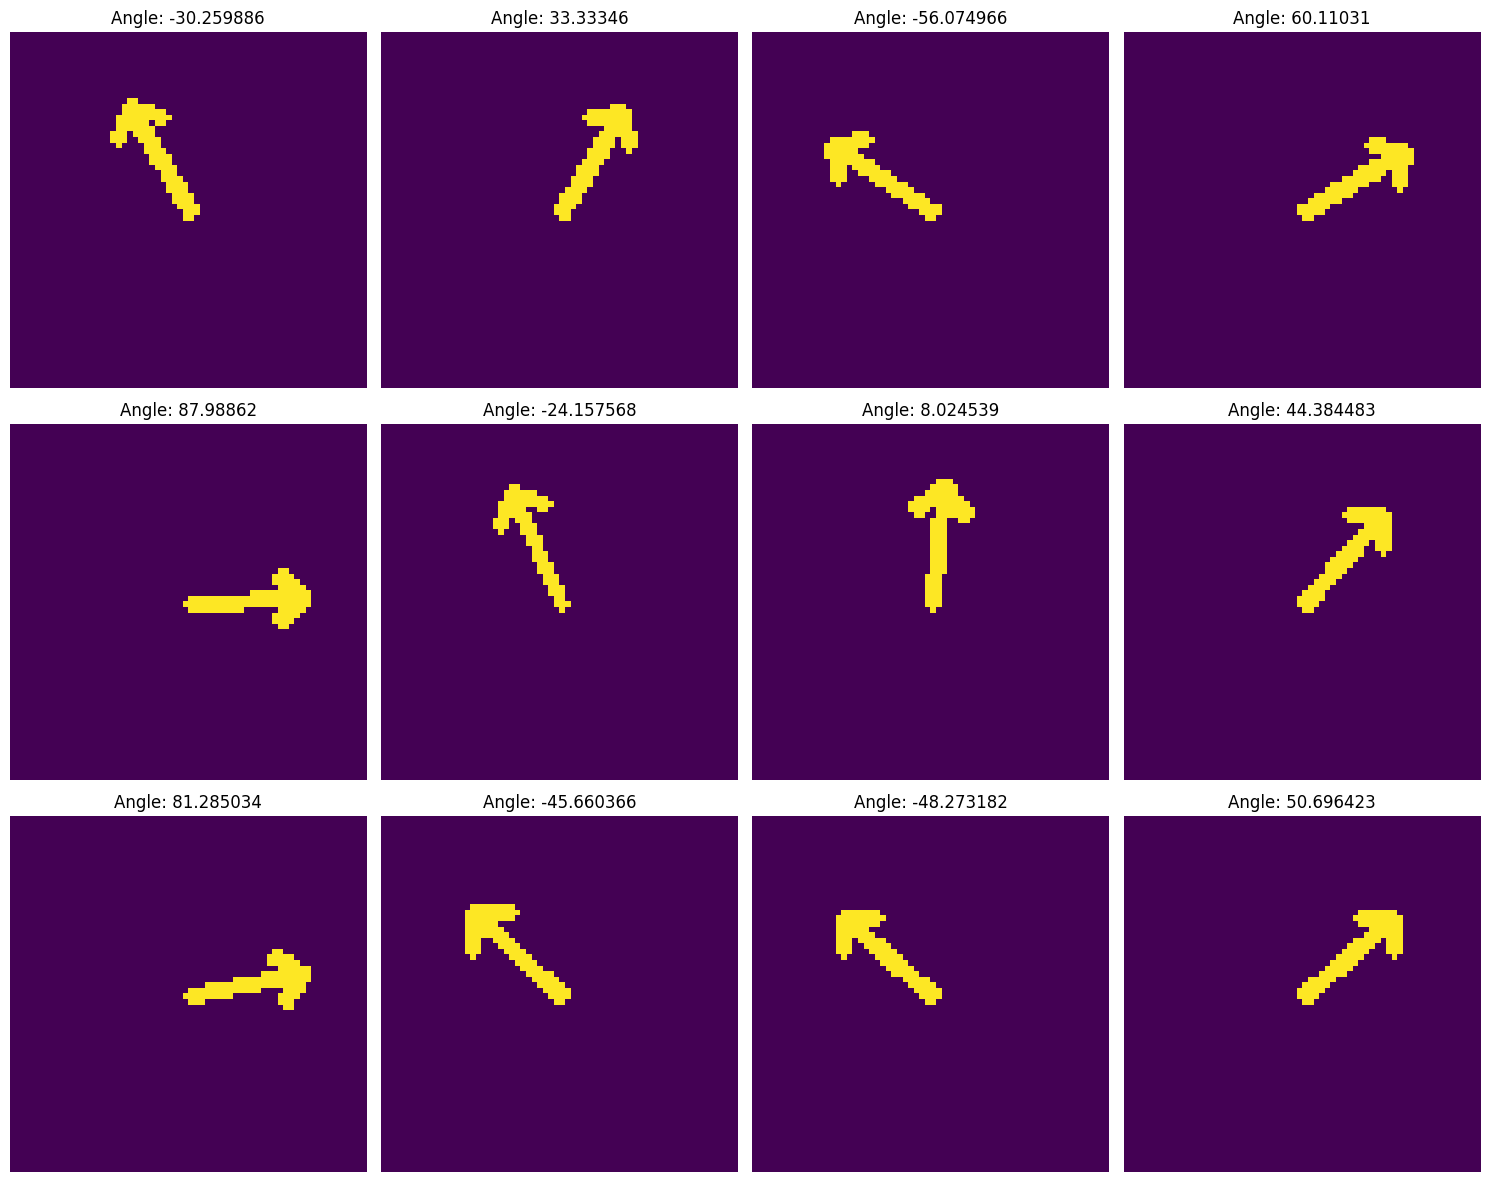

In [5]:
# Display several examples (12)
fig, axes = plt.subplots(3, 4, figsize=(15, 12))
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i])
    ax.set_title(f'Angle: {angles[i]}')
    ax.axis('off')
plt.tight_layout()
plt.show()

<ins>Note :</ins> Each angle is between -90 and 90 degrees. The angles are continuous values, measured in degrees and represent the orientation of the object in the image with respect to the y-axis (vertical axis). An angle of 0 degrees indicates that the object is perfectly vertical, while positive angles indicate a clockwise rotation and negative angles indicate a counterclockwise rotation.

## Objective of the project

The objective of this project is to build and train a Convolutional Neural Network (CNN) model that can accurately predict the angle of rotation of the arrows in each image. 

To achieve this, we will follow these steps:
1. Data Preprocessing: Given that we have generated the dataset ourselves, we do not need to perform extensive data cleaning or preprocessing. Indeed, the images are already in a suitable format for training a CNN model. The pixel values are also binary (0 or 1 - black and white images), and so the images are already normalized.

2. Splitting the Dataset: We will split the dataset into training, validation, and test sets. The training set will be used to train the model, the validation set will be used to tune hyperparameters and evaluate the model during training, and the test set will be used to assess the final performance of the model.
<ins>Attention :</ins> Since the target variable (angle) is continuous, we will use stratified sampling based on binned angle values to ensure that each set has a representative distribution of angles.

3. Model Architecture: We designed a simple CNN architecture suitable for regression tasks. The model consists of several convolutional layers followed by fully connected layers. The final layer has a single neuron with a linear activation function to output the predicted angle.

4. Training the Model: We will compile the model using a loss function suitable for regression tasks, such as Mean Squared Error (MSE) or Root Mean Squared Error (RMSE). We will then train the model using the training set and validate it using the validation set, using different **activation functions** and **initialization methods** to compare their performance, and highlight the importance of these choices in regression tasks (and therefore in classification tasks as well).

---

In [6]:
bins = [-90, -60, -30, 0, 30, 60, 90]
angles_binned = np.digitize(angles, bins)
print('Binned angle distribution:')
for i in range(1, len(bins)):
    count = np.sum(angles_binned == i)
    print(f'Bin {bins[i-1]} to {bins[i]}: {count} samples')

Binned angle distribution:
Bin -90 to -60: 158 samples
Bin -60 to -30: 171 samples
Bin -30 to 0: 165 samples
Bin 0 to 30: 193 samples
Bin 30 to 60: 166 samples
Bin 60 to 90: 147 samples


In [7]:
X_train, X_temp, y_train, y_temp = train_test_split(images, angles, test_size=0.3, random_state=42, stratify=angles_binned)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=np.digitize(y_temp, bins))

In [8]:
print(f'Training set size: {len(X_train)}')
print("")
# Bins distribution in training set
train_binned = np.digitize(y_train, bins)
print('Binned angle distribution (training set):')
for i in range(1, len(bins)):
    count = np.sum(train_binned == i)
    print(f'Bin {bins[i-1]} to {bins[i]}: {count} samples')
print("--------------------------------")

print(f'Validation set size: {len(X_val)}')
# Bins distribution in validation set
val_binned = np.digitize(y_val, bins)
print('Binned angle distribution (validation set):')
for i in range(1, len(bins)):
    count = np.sum(val_binned == i)
    print(f'Bin {bins[i-1]} to {bins[i]}: {count} samples')
print("--------------------------------")

print(f'Test set size: {len(X_test)}')
# Bins distribution in test set
test_binned = np.digitize(y_test, bins)
print('Binned angle distribution (test set):')
for i in range(1, len(bins)):
    count = np.sum(test_binned == i)
    print(f'Bin {bins[i-1]} to {bins[i]}: {count} samples')
print("--------------------------------")

Training set size: 700

Binned angle distribution (training set):
Bin -90 to -60: 111 samples
Bin -60 to -30: 120 samples
Bin -30 to 0: 115 samples
Bin 0 to 30: 135 samples
Bin 30 to 60: 116 samples
Bin 60 to 90: 103 samples
--------------------------------
Validation set size: 150
Binned angle distribution (validation set):
Bin -90 to -60: 23 samples
Bin -60 to -30: 26 samples
Bin -30 to 0: 25 samples
Bin 0 to 30: 29 samples
Bin 30 to 60: 25 samples
Bin 60 to 90: 22 samples
--------------------------------
Test set size: 150
Binned angle distribution (test set):
Bin -90 to -60: 24 samples
Bin -60 to -30: 25 samples
Bin -30 to 0: 25 samples
Bin 0 to 30: 29 samples
Bin 30 to 60: 25 samples
Bin 60 to 90: 22 samples
--------------------------------


---

### Considered activation functions:

To assess the impact of activation functions on regression tasks using CNNs, we will consider the following activation functions:
- ReLU (Rectified Linear Unit)
- Tanh (Hyperbolic Tangent)
- Sigmoid
- PReLU (Parametric ReLU)

Given the nature of our regression task, we expect that some activation functions may perform better than others. For instance, we don't expect ReLU to perform well, given how it is defined:

$$
f(x) = max(0, x)
$$

so 

$$
\forall x < 0, f(x) = 0
$$

which can lead to negative values being completely ignored during training: this is problematic for our task, given that our angles can be negative (between -90 and 90 degrees).


### Initialization methods:

We will also explore different weight initialization methods to see how they affect the training and performance of the CNN model. The considered initialization methods are:
- Uniform Initialization
- Xavier Initialization
- He Initialization

### Loss function:

For regression tasks, we will use the Mean Squared Error (MSE) loss function, which is defined as:
$$
MSE = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
$$
where $y_i$ is the true value, $\hat{y}_i$ is the predicted value, and $n$ is the number of samples.

---

In [9]:
# Activation functions
conv_activations = [nn.ReLU(), nn.Sigmoid(), nn.PReLU()]
fc_activations   = [nn.ReLU(), nn.Sigmoid(), nn.PReLU()]

# Initialization methods
initializations = [
    "uniform",
    "xavier",
    "he"
]

# Number of epochs
num_epochs = 100

# loss function
loss_function = nn.MSELoss()

---

## Ready the data for the training, validation and testing

In [10]:
# Create Dataset instances
train_dataset = ArrowDataset(X_train, y_train)
val_dataset   = ArrowDataset(X_val, y_val)
test_dataset  = ArrowDataset(X_test, y_test)

# Create DataLoaders
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [12]:
x0, y0 = next(iter(train_loader))
print("Batch shape:", x0.shape)  # attendu: (batch, 1, 64, 64)

Batch shape: torch.Size([32, 1, 64, 64])


In [15]:
test_model = CNN(init_type="xavier", conv_activation_function="relu", fc_activation_function="relu")

total = sum(p.numel() for p in test_model.parameters() if p.requires_grad)
print(f"Params entraînables: {total:,}")

Params entraînables: 125,953


In [14]:
models = []
training_avg_mse_losses = []
validation_avg_mse_losses = []


for conv_activation in conv_activations:
    for fc_activation in fc_activations:
        for init in initializations:
            print(f'Model {len(models)+1}/{len(conv_activations)*len(fc_activations)*len(initializations)} - Training CNN with {conv_activation} activation for convolutional layers and {fc_activation} activation for fully connected layers, and {init} initialization')
            model = CNN(init_type=init, conv_activation_function=conv_activation, fc_activation_function=fc_activation)

            # Training code
            optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
            
            for epoch in range(num_epochs):
                model.train()
                train_losses = []
                for images_batch, angles_batch in train_loader:
                    optimizer.zero_grad()
                    outputs = model(
                        images_batch,
                        conv_activation_function=conv_activation,
                        fc_activation_function=fc_activation
                    )
                    loss = loss_function(outputs.squeeze(), angles_batch.float())
                    loss.backward()
                    optimizer.step()
                    train_losses.append(loss.item())
                
                avg_train_loss = np.mean(train_losses)
                
                model.eval()
                val_losses = []
                with torch.no_grad():
                    for images_batch, angles_batch in val_loader:
                        outputs = model(
                            images_batch,
                            conv_activation_function=conv_activation,
                            fc_activation_function=fc_activation
                        )
                        loss = loss_function(outputs.squeeze(), angles_batch.float())
                        val_losses.append(loss.item())
                avg_val_loss = np.mean(val_losses)
                
                if (epoch+1) % 20 == 0:
                    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
                    
            models.append(model)
            training_avg_mse_losses.append(avg_train_loss)
            validation_avg_mse_losses.append(avg_val_loss)
            print("-----------------------------------------------------")

Model 1/27 - Training CNN with ReLU() activation for convolutional layers and ReLU() activation for fully connected layers, and uniform initialization


KeyboardInterrupt: 

In [ ]:
# Associate each model with its configuration
model_configurations = []
for conv_activation in conv_activations:
    for fc_activation in fc_activations:
        for init in initializations:
            config = {
                'conv_activation': conv_activation,
                'fc_activation': fc_activation,
                'initialization': init
            }
            model_configurations.append(config)

In [ ]:
# Plot the training and validation losses for each model in subplots (total/2, 2 columns)
num_models = len(models)
fig, axes = plt.subplots(num_models // 2 + num_models % 2, 2, figsize=(12, num_models * 3))
axes = axes.flatten()
for i in range(num_models):
    axes[i].plot(training_avg_mse_losses[i], label='Training Loss')
    axes[i].plot(validation_avg_mse_losses[i], label='Validation Loss')
    axes[i].set_title(f'Model {i+1} Losses - Conv: {type(model_configurations[i]["conv_activation"]).__name__}, FC: {type(model_configurations[i]["fc_activation"]).__name__}, Init: {model_configurations[i]["initialization"]}')
    axes[i].set_xlabel('Epoch')
    axes[i].set_ylabel('MSE Loss')
    axes[i].legend()
    axes[i].grid()
plt.suptitle('Training and Validation Losses for Different CNN Configurations', fontsize=16)
plt.savefig('training_validation_losses.png')
plt.tight_layout()
plt.show()